In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import sys
import matplotlib as mpl

#insert path
sys.path.insert(0, '../methods/')

sys.modules.pop('generate_syn_data', None)
from generate_syn_data import *

sys.modules.pop('ARWQE', None)
from ARWQE import *

sys.modules.pop('plots', None)
from plots import *

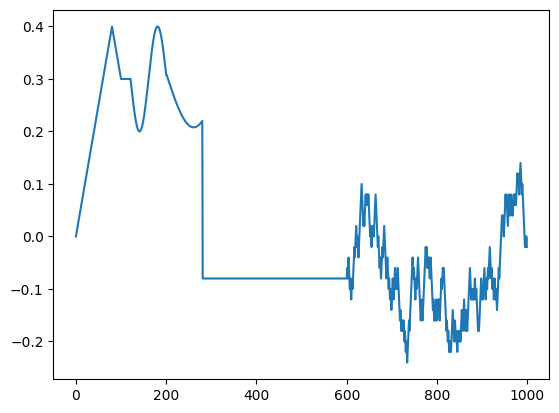

50it [16:58, 20.37s/it]


In [7]:
alpha =0.1; delta = 0.1; gamma=1
num_periods = 1000
num_trials = 50
dimX = 5

#NOTE: uncomment to change shift patterns

""" #stationary case:
shift = 'stationary'
beta = np.ones((num_periods, dimX)) /5 """

#non-stationary case
beta_1 = generate_true_means(num_periods-1, 40, 10)
beta_2 = generate_true_means(num_periods-1, 40, 10)
beta_3 = generate_true_means(num_periods-1, 40, 10)
beta_4 = generate_true_means(num_periods-1, 40, 10)
beta_5 = generate_true_means(num_periods-1, 40, 10)
beta = 2 * np.column_stack((beta_1, beta_2, beta_3, beta_4, beta_5)) 
plt.plot(beta_1)
plt.show() 
rho_values = [0.99, 0.9, 0.5, 0.25]

variance_y = 1; meanX = 0 

np.random.seed(6)

#B_arr is for val set
B_arr = np.random.randint(low=1, high=10, size=num_periods)
B_arr_starts = np.arange(num_periods)
B_arr_ends = np.cumsum(B_arr) - 1

#for training set
B_arr_tr = 3 * B_arr

#NOTE: all the above can be tuned

fixed_windows = [1, 4, 16, 64, 256, 1024]
train_windows = [1, 64, 256, 1024]

cdf_array = np.empty((num_trials, len(fixed_windows)+1+len(rho_values), len(train_windows), num_periods))
interval_array = np.empty((num_trials, len(fixed_windows)+1+len(rho_values), len(train_windows), num_periods))

seeds = np.arange(num_trials) + 2024
#seeds = np.arange(num_trials, num_trials*2) +2024

for (trial, seed) in tqdm(enumerate(seeds)):

    np.random.seed(seed)

    X_tr, y_tr = generate_linreg_data(meanX, B_arr_tr, beta, variance_y)
    X_val, y_val = generate_linreg_data(meanX, B_arr, beta, variance_y)

    for t in range(num_periods):

        tr_end = B_arr_ends[t]+1
        B_arr_t = B_arr[:t+1]

        for m, train_window in enumerate(train_windows):

            # use fixed windows for training
            tr_start = B_arr_starts[t-min(t,train_window)]
            reg, S_t = fit_and_get_scores(X_tr[tr_start:tr_end], y_tr[tr_start:tr_end],\
                                           X_val[:tr_end], y_val[:tr_end])

            khat, qt_khat, qtk_all = ARWQE(S_t, B_arr_t, alpha, delta, gamma)

            #compute coverage
            dimX = X_tr.shape[1]

            #approximate by generating ~1000 X, Y from this period
            # and calculate coverage of prediction set
            X_test = generate_multinomial_X(meanX, dimX, 1000)
            y_hat = reg.predict(X_test)

            mu_test = X_test @ beta[t].T
            Y_test = mu_test + np.random.normal(0, variance_y, 1000)

            coverage_ARW = monte_carlo_coverage(y_hat, qt_khat, Y_test)
            cdf_array[trial, 0, m, t] = coverage_ARW
            interval_array[trial, 0, m, t] = 2*qt_khat

            #baseline: weighted quantile
            for r, rho in enumerate(rho_values):
              qw = QE_weighted(S_t, B_arr_t, alpha, rho)
              coverage_w = monte_carlo_coverage(y_hat, qw, Y_test)
              cdf_array[trial, 1+r, m, t] = coverage_w
              interval_array[trial, 1+r, m, t] = 2*qw

            #baseline: take quantile of fixed k
            for ik, k in enumerate(fixed_windows):
                log2k = int(np.log2(k))
                qtk = qtk_all[min(log2k, len(qtk_all)-1)]
                coverage_k = monte_carlo_coverage(y_hat, qtk, Y_test)
                cdf_array[trial, ik+1+len(rho_values), m, t] = coverage_k
                interval_array[trial, ik+1+len(rho_values), m, t] = 2*qtk



[0.03490867 0.08561553 0.08550276 0.08369449 0.08184473 0.15331942
 0.05811427 0.03327698 0.03568991 0.05747542 0.08561553]
[0.03509293 0.08510416 0.08499138 0.08325767 0.08147473 0.15327644
 0.05806016 0.03329069 0.03584807 0.05704447 0.08510416]
[0.03582607 0.0826136  0.08249484 0.08076607 0.07905093 0.15327449
 0.05804727 0.0331934  0.03610136 0.05527513 0.0826136 ]
[0.03620516 0.07987062 0.07974002 0.07792507 0.07612898 0.15325376
 0.05806953 0.03320731 0.03635891 0.05432953 0.07987062]


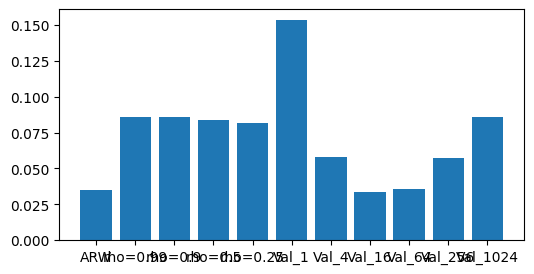

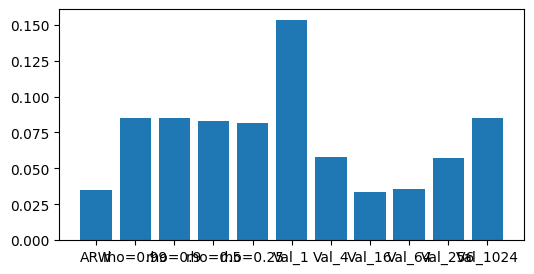

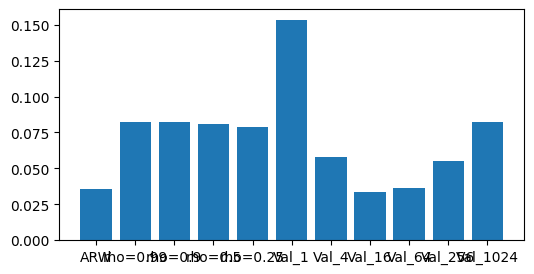

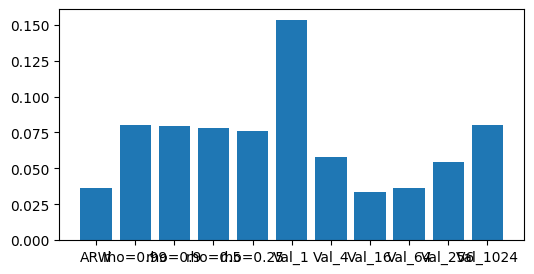

In [9]:
#process results in cdf_dict
methods = ['ARW'] + [f'rho={rho}' for rho in rho_values] + [f'Val_{k}' for k in fixed_windows]

mae_array = np.abs(cdf_array - 1 + alpha)
mse_array = (cdf_array - 1 + alpha)**2

results = {}
for m in range(len(train_windows)):
    mae = np.mean(np.mean(mae_array[:, :, m, 100:], axis=2), axis=0)
    se_ae = np.std(np.mean(mae_array[:, :, m, 100:], axis=2), axis=0) / np.sqrt(num_trials)

    interval = np.mean(np.mean(interval_array[:, :, m, 100:], axis=2), axis=0)
    se_interval = np.std(np.mean(interval_array[:, :, m, 100:], axis=2), axis=0) / np.sqrt(num_trials)
    print(mae)
    results[train_windows[m]] = (mae, se_ae, interval, se_interval)
    
    plt.figure(figsize=(6,3))
    plt.bar(methods, mae)

In [10]:
np.save('./results/linreg_nonstationary_cdf_array_1_rhos.npy', cdf_array, allow_pickle=True)
np.save('./results/linreg_nonstationary_itv_array_1_rhos.npy', interval_array, allow_pickle=True)

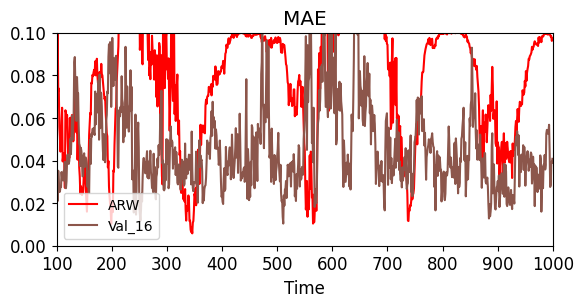

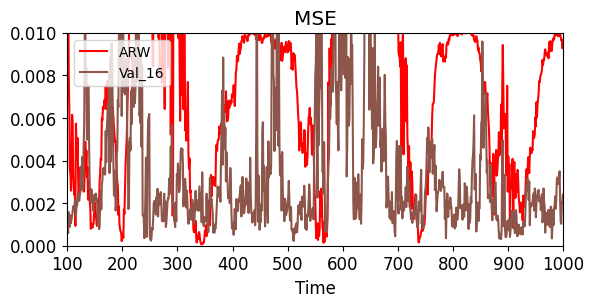

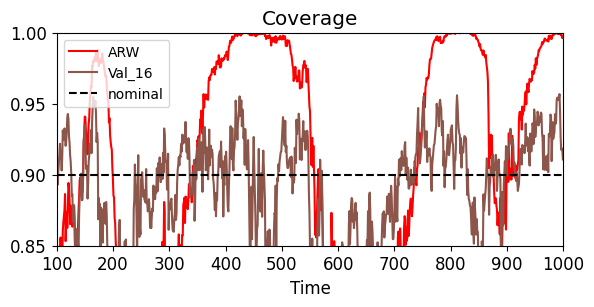

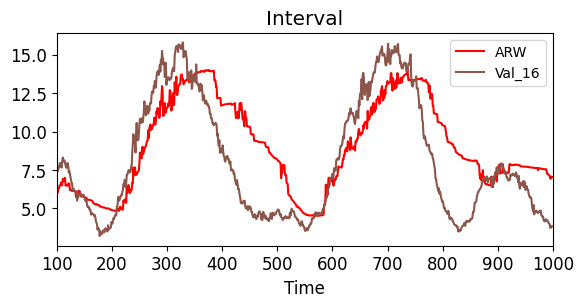

In [36]:
#plot cdf over time periods for ARW, V1, V256
colors = ['r', '#FFA500', 'tab:purple', 'tab:brown', 'tab:green', '#0096FF', 'tab:gray']
methods = ['ARW', 'Val_1', 'Val_4', 'Val_16', 'Val_64', 'Val_256', 'Val_1024']

#NOTE: uncomment to change the index of the methods to plot
methods_to_plot = [0, 3]

mae_over_trials = np.mean(mae_array[:, :, :], axis=1)
mse_over_trials = np.mean(mse_array[:, :, :], axis=1)
cdf_over_trials = np.mean(cdf_array[:, :, :], axis=1)
interval_over_trials = np.mean(interval_array[:, :, :], axis=1)

plot_over_time(colors, methods, 100, 1000, mae_over_trials, methods_to_plot, title='MAE')
#NOTE: adjust ylim for zooming in 
plt.ylim(0, 0.1)

plot_over_time(colors, methods, 100, 1000, mse_over_trials, methods_to_plot, title='MSE')
plt.ylim(0, 0.01)

plot_over_time(colors, methods, 100, 1000, cdf_over_trials, methods_to_plot, title='Coverage', alpha=0.1)
plt.ylim(0.85, 1.0)
plot_over_time(colors, methods, 100, 1000, interval_over_trials, methods_to_plot, title='Interval')

#plt.savefig(f'{DATAPATH}/{figname}_time_var{variance}.png', dpi=300, bbox_inches='tight')